# Import package and initialize model

In [1]:
from branch_calm_net.models import *

DEVICE = torch.device('cpu')

# GROUPING DECLARATION
subject_group = { # map: ID_# -> group_id
    "ID_0": '0',
    "ID_1": '1',
    "ID_2": '2'
}

# MODEL CONFIGURATION and TRAINING PARAMETERS
config = {
    'model_params': {
        'device': DEVICE,
        'in_size': 8,
        'AE': 'lstm', 
        'AE_num_layers': 1,
        'AE_hidden_size': 128,
        'covariate_size': 4, # number of covariates
        'shared_in_size': 128, # init bottleneck size
        'shared_hidden_size': 256,
        'num_branches': 3, # when equal to 1, it is equivalent to CALM_Net
        'groups': subject_group,
        'heads_hidden_size': 64,
        'num_classes': 2
    },
    'training_params': {
        'device': torch.device('cpu'), 
        'loss_weight': {
            'alpha': 1e-4,
            'beta': 1,
            'theta': 1 / 22, # 1 over number of students
        },
        # 'class_weights': [0.6456, 0.5635, 1.0000],
        'class_weights': [0.6456, 0.5635+1.0000],
        'global_lr': 1e-5,
        'branching_lr': 1e-5,
        'weight_decay': 1e-4,
        'epochs': 20, 
        'batch_size': 4,
        'use_histogram': True,
        'use_covariates': True, 
        'use_decoder': True,
    }
}

# CONSTUCT MODEL
model = MultitaskAutoencoder(config['model_params'], use_covariates=True).to(DEVICE)
model.eval()

MultitaskAutoencoder(
  (autoencoder): autoencoder(
    (encoder): LSTM(8, 128, batch_first=True)
    (encoder_act): ReLU()
    (decoder): LSTM(128, 8, batch_first=True)
    (decoder_act): Sigmoid()
  )
  (branching): branching(
    (probabilities): ParameterDict(
        (0): Parameter containing: [torch.FloatTensor of size 3]
        (1): Parameter containing: [torch.FloatTensor of size 3]
        (2): Parameter containing: [torch.FloatTensor of size 3]
    )
  )
  (branch_layer): branch_layer(
    (branches): ModuleDict(
      (0): Sequential(
        (0): Linear(in_features=132, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=132, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=132, out_

# Example Input and Prediction Output

In [2]:
# GENERATE RANDOM EXAMPLE DATA
sample_x = torch.rand(3, 24, 8).to(DEVICE) # N, L, D
sample_ids = ['1', '0', '2']
sample_cov = torch.rand(3, 4).to(DEVICE) # N, E_c

# FORWARD PASS
final_out, AE_out = model(sample_x, sample_ids, covariate_data=sample_cov)

# print
print("Input Size:", sample_x.shape)
print("Covariates Size:", sample_cov.shape)
print("Prediction Output Size:", final_out.shape)
print("Decoder Output Size:", AE_out.shape)

Input Size: torch.Size([3, 24, 8])
Covariates Size: torch.Size([3, 4])
Prediction Output Size: torch.Size([3, 2])
Decoder Output Size: torch.Size([3, 24, 8])


# Train the model

100%|██████████| 20/20 [00:01<00:00, 19.57it/s]


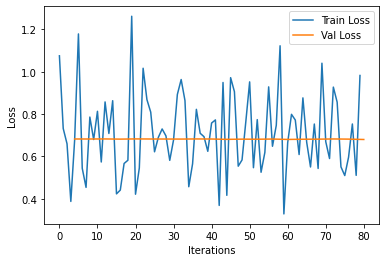

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# GENERATE RANDOM EXAMPLE DATA
sample_x = torch.rand(16, 24, 8).to(DEVICE) # N, L, D
sample_y = torch.rand(16, 2).to(DEVICE) # N, C
sample_ids = np.random.choice(['1', '0', '2'], 16, replace=True)
sample_cov = torch.rand(16, 4).to(DEVICE) # N, E_c

val_x = torch.rand(2, 24, 8).to(DEVICE) # N, L, D
val_y = torch.rand(2, 2).to(DEVICE) # N, C
val_ids = np.random.choice(['1', '0', '2'], 2, replace=True)
val_cov = torch.rand(2, 4).to(DEVICE) # N, E_c

# fit function
train_loss, train_it, val_loss, val_it = model.fit(
    config,
    sample_x,
    sample_y,
    sample_ids,
    sample_cov=sample_cov,
    val_x=val_x,
    val_y=val_y,
    val_ids=val_ids,
    val_cov=val_cov
)

# check function
plt.plot(train_it, train_loss, label="Train Loss")
plt.plot(val_it, val_loss, label="Val Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()